# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 9

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_within_distance"
    / "gls-1000g_mashr-test-sub_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-test-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-test-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-test-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-test-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-test-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-test-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(9000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV45,0.017158,0.010311,1.663997,0.096162,0.048081,random.pheno988
1,LV234,0.019725,0.012166,1.621258,0.105011,0.052506,random.pheno988
2,LV847,0.010579,0.012894,0.820429,0.412002,0.206001,random.pheno988
3,LV110,-0.020189,0.013525,-1.492696,0.135566,0.932217,random.pheno988
4,LV769,0.013242,0.011701,1.131735,0.257788,0.128894,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.07866666666666666

It should be around 0.05. Let's check what happened at individual LVs.

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(9, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV110,0.009,0.040,0.066
1,LV234,0.017,0.059,0.108
2,LV412,0.081,0.165,0.229
3,LV45,0.021,0.064,0.123
4,LV57,0.009,0.052,0.103


In [21]:
summary_df.describe()

,1,5,10
count,9.000000,9.000000,9.000000
mean,0.027444,0.078667,0.130444
std,0.024208,0.042541,0.057272
min,0.009000,0.040000,0.066000
25%,0.010000,0.057000,0.102000
50%,0.021000,0.061000,0.108000
75%,0.024000,0.073000,0.123000
max,0.081000,0.165000,0.229000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(0, 4)

,lv,1,5,10


,lv,1,5,10


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(5, 4)

,lv,1,5,10
8,LV847,0.024,0.061,0.102
3,LV45,0.021,0.064,0.123
5,LV647,0.023,0.073,0.123
6,LV769,0.053,0.137,0.225
2,LV412,0.081,0.165,0.229


# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV45,0.017158,0.010311,1.663997,0.096162,0.048081,random.pheno988
9,LV45,0.011345,0.010315,1.099888,0.271422,0.135711,random.pheno589
18,LV45,0.005120,0.010314,0.496377,0.619645,0.309823,random.pheno385
27,LV45,0.006569,0.010304,0.637538,0.523797,0.261899,random.pheno5
36,LV45,-0.016810,0.010301,-1.631928,0.102744,0.948628,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.021

In [31]:
show_prop(results, 0.05)

0.064

In [32]:
show_prop(results, 0.10)

0.123

In [33]:
show_prop(results, 0.15)

0.164

In [34]:
show_prop(results, 0.20)

0.202

### QQplot

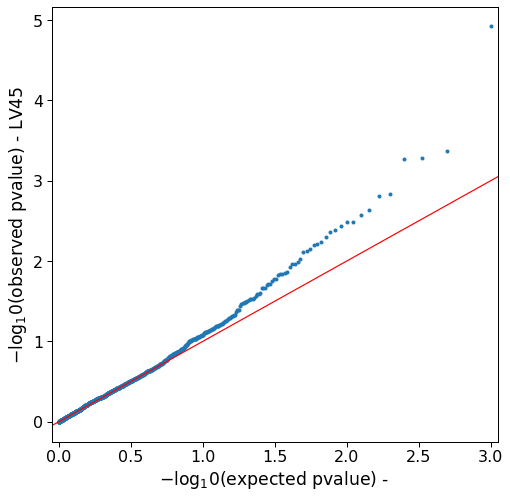

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
1,LV234,0.019725,0.012166,1.621258,0.105011,0.052506,random.pheno988
10,LV234,0.000030,0.012148,0.002446,0.998049,0.499024,random.pheno589
19,LV234,-0.012152,0.012150,-1.000146,0.317277,0.841361,random.pheno385
28,LV234,0.009489,0.012146,0.781202,0.434712,0.217356,random.pheno5
37,LV234,0.003346,0.012176,0.274829,0.783456,0.391728,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.017

In [42]:
show_prop(results, 0.05)

0.059

In [43]:
show_prop(results, 0.10)

0.108

In [44]:
show_prop(results, 0.15)

0.147

In [45]:
show_prop(results, 0.20)

0.178

### QQplot

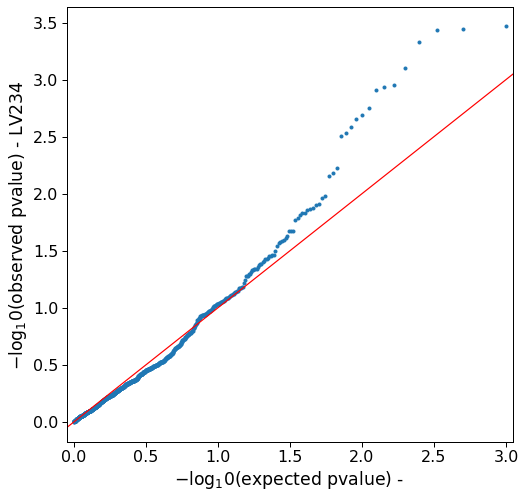

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
2,LV847,0.010579,0.012894,0.820429,0.412002,0.206001,random.pheno988
11,LV847,0.003463,0.012914,0.268135,0.788604,0.394302,random.pheno589
20,LV847,-0.014811,0.012898,-1.148340,0.250871,0.874564,random.pheno385
29,LV847,0.007757,0.012882,0.602197,0.547064,0.273532,random.pheno5
38,LV847,0.007529,0.012934,0.582095,0.560523,0.280262,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.024

In [53]:
show_prop(results, 0.05)

0.061

In [54]:
show_prop(results, 0.10)

0.102

In [55]:
show_prop(results, 0.15)

0.144

In [56]:
show_prop(results, 0.20)

0.189

### QQplot

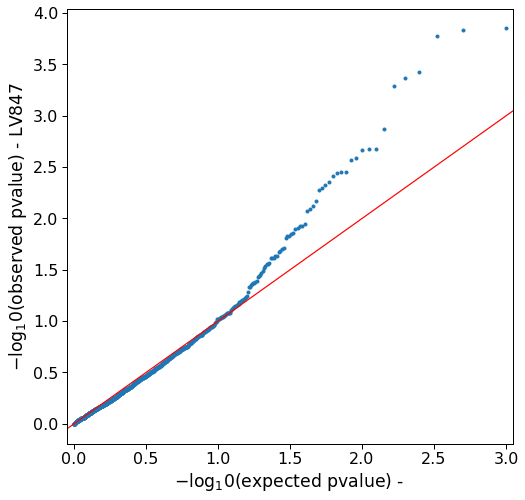

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
3,LV110,-0.020189,0.013525,-1.492696,0.135566,0.932217,random.pheno988
12,LV110,-0.007151,0.013523,-0.528802,0.596961,0.701519,random.pheno589
21,LV110,-0.023209,0.013514,-1.717347,0.085964,0.957018,random.pheno385
30,LV110,-0.009430,0.013473,-0.699913,0.484007,0.757997,random.pheno5
39,LV110,0.000286,0.013520,0.021163,0.983116,0.491558,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.009

In [64]:
show_prop(results, 0.05)

0.04

In [65]:
show_prop(results, 0.10)

0.066

In [66]:
show_prop(results, 0.15)

0.114

In [67]:
show_prop(results, 0.20)

0.154

### QQplot

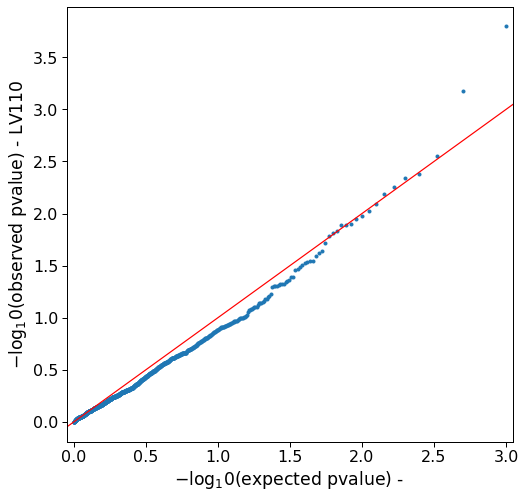

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
4,LV769,0.013242,0.011701,1.131735,0.257788,0.128894,random.pheno988
13,LV769,0.000137,0.011666,0.011757,0.990619,0.495310,random.pheno589
22,LV769,0.002130,0.011681,0.182380,0.855290,0.427645,random.pheno385
31,LV769,-0.015242,0.011677,-1.305288,0.191841,0.904079,random.pheno5
40,LV769,-0.018180,0.011701,-1.553758,0.120291,0.939854,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.053

In [75]:
show_prop(results, 0.05)

0.137

In [76]:
show_prop(results, 0.10)

0.225

In [77]:
show_prop(results, 0.15)

0.296

In [78]:
show_prop(results, 0.20)

0.343

### QQplot

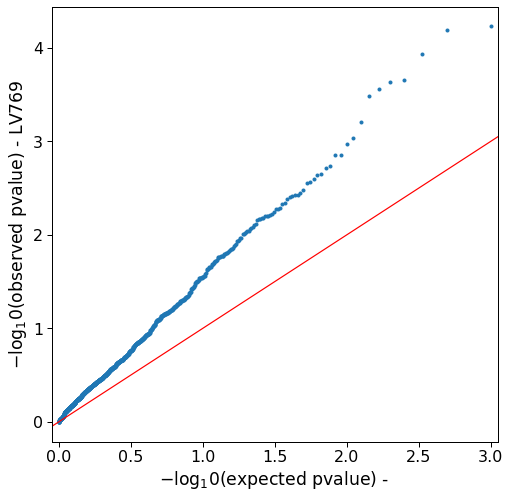

In [79]:
qqplot_unif(results)

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
5,LV800,0.006051,0.013735,0.440557,0.659549,0.329774,random.pheno988
14,LV800,-0.006443,0.013741,-0.468850,0.639192,0.680404,random.pheno589
23,LV800,-0.001106,0.013758,-0.080419,0.935906,0.532047,random.pheno385
32,LV800,-0.019237,0.013767,-1.397292,0.162374,0.918813,random.pheno5
41,LV800,-0.007238,0.013716,-0.527709,0.597720,0.701140,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.01

In [86]:
show_prop(results, 0.05)

0.057

In [87]:
show_prop(results, 0.10)

0.095

In [88]:
show_prop(results, 0.15)

0.149

In [89]:
show_prop(results, 0.20)

0.197

### QQplot

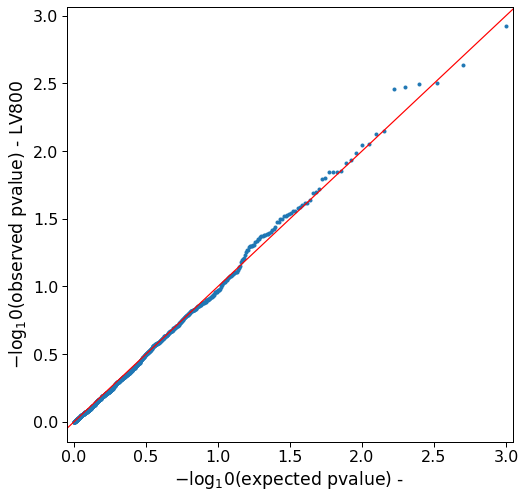

In [90]:
qqplot_unif(results)

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10


In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
6,LV412,0.016508,0.009188,1.796633,0.072441,0.036220,random.pheno988
15,LV412,0.007314,0.009139,0.800323,0.423553,0.211777,random.pheno589
24,LV412,-0.019557,0.009138,-2.140098,0.032384,0.983808,random.pheno385
33,LV412,0.009512,0.009186,1.035436,0.300504,0.150252,random.pheno5
42,LV412,0.014069,0.009138,1.539659,0.123693,0.061846,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.081

In [99]:
show_prop(results, 0.05)

0.165

In [100]:
show_prop(results, 0.10)

0.229

In [101]:
show_prop(results, 0.15)

0.279

In [102]:
show_prop(results, 0.20)

0.311

### QQplot

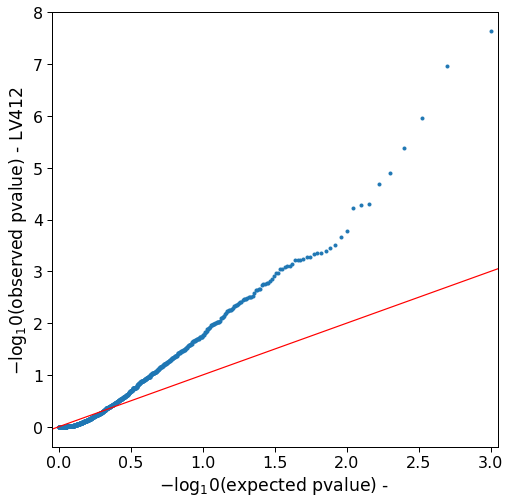

In [103]:
qqplot_unif(results)

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
7,LV57,-0.020515,0.012283,-1.670228,0.094923,0.952539,random.pheno988
16,LV57,0.017261,0.012286,1.404907,0.160097,0.080049,random.pheno589
25,LV57,0.017857,0.012290,1.452975,0.146280,0.073140,random.pheno385
34,LV57,-0.000340,0.012278,-0.027722,0.977885,0.511058,random.pheno5
43,LV57,0.012505,0.012246,1.021099,0.307246,0.153623,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.009

In [110]:
show_prop(results, 0.05)

0.052

In [111]:
show_prop(results, 0.10)

0.103

In [112]:
show_prop(results, 0.15)

0.141

In [113]:
show_prop(results, 0.20)

0.179

### QQplot

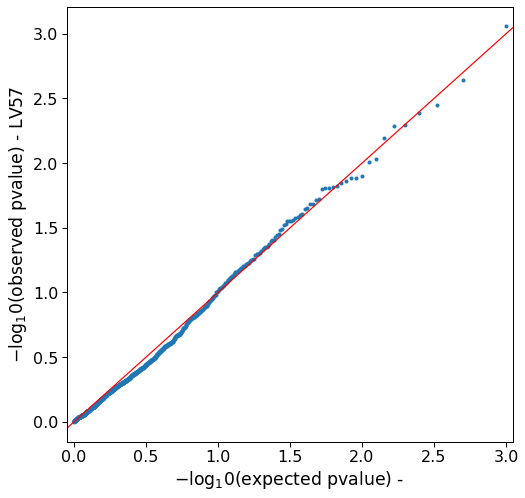

In [114]:
qqplot_unif(results)

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
8,LV647,-0.008585,0.011289,-0.760477,0.446997,0.776501,random.pheno988
17,LV647,0.010610,0.011283,0.940312,0.347093,0.173546,random.pheno589
26,LV647,0.009133,0.011288,0.809110,0.418482,0.209241,random.pheno385
35,LV647,0.003182,0.011290,0.281843,0.778073,0.389037,random.pheno5
44,LV647,0.013461,0.011262,1.195225,0.232043,0.116022,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.023

In [121]:
show_prop(results, 0.05)

0.073

In [122]:
show_prop(results, 0.10)

0.123

In [123]:
show_prop(results, 0.15)

0.163

In [124]:
show_prop(results, 0.20)

0.209

### QQplot

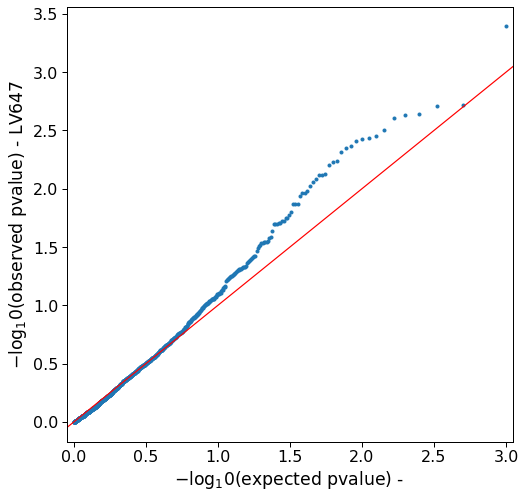

In [125]:
qqplot_unif(results)